# MS Data Processing
With this code you can analyse MS spectra taken with a Bruker Solarix 12T mass spectrometer.

The directory tree should be organised as follows:

[//]: # (<img src="dir_tree_&_workflow.png" width="1200"/>)

``````
MS processing code directory  
├─ Raw data processing code  
├─ CSV generating code  
└─ Plot generating code  

MS data directory  
├─ Run order csv file  
├─ DB directory  
│   └─ molformulas.sqlite  
├─ Spectra.d file  
│   ├─ all the blank.d  
│   ├─ all the ctrl.d  
│   └─ all the samples.d  
├─ Logs dir  
│   └─ all the logs.txt  
├─ CSV files dir  
│   ├─ individual samples' CSVs  
│   ├─ intrinsic error plots dir  
│   ├─ interlab CSVs  
│   └─ processed CSV (for further analysis)  
├─ Hawkes file  
├─ Parameters.txt file  
└─ Plots dir  
    └─ individual samples' dirs  
        ├─ plots.svg  
        └─ Kendrick plots dir  
            └─ Kendrick plots.svg
``````

For the code to work, please modify the variables in the first cell so as to direct the code towards the desired folders and files.

In [1]:
# Python 3.10.11

import numpy as np # v. 1.22.1
from matplotlib import pyplot as plt # v. 3.7.5
import os
import pandas as pd # v. 1.5.3
import seaborn as sns # v. 0.12.2
import pykrev as pk # v. 1.2.4
import datetime
import sys
sys.path.append('../mchem_functions/')
import ms_functions_and_defs as msf

from corems.transient.input.brukerSolarix import ReadBrukerSolarix # v. 1.6.0
from corems.encapsulation.factory.parameters import MSParameters
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas

In [2]:
# Set the correct folders for the MS files.

# Specify the folder where the MS data is, with the directory tree shown above.
general_dir = '../../Data/MS_data' #'../../MS_data

# Important folders and files, without the general_dir prefix
spectra_folder = 'ms_files'
run_order = 'run_order.csv'
ref_file_location = 'Hawkes_neg.ref'
param_file = 'parameters.txt'
decon90_file = 'Decon90_04-02-2025_000001.csv'
chosen_dates = ['11/04/2025'] # dd/mm/yyyy 06/12/2024

# If you want to run just specific samples, please specify:
chosen_samples_name = []

# Change truth value if you do/don't want them
filter_noise = 1
intr_err_known = 1

calibration = intr_err_known
logs = intr_err_known
remove_blanks = intr_err_known
save = intr_err_known

In [3]:
# Change directory to the general_dir
try: os.chdir(general_dir)
except FileNotFoundError: pass

In [4]:
# Declare folder db where the molformulas.sqlite file will be created and stored.
db = r'C:\db' #f'db'
if not os.path.exists(db): os.mkdir(db)

In [5]:
def read_params(file_name:str,sep='\n---\n',comment='#'):
    '''
    You can use the read_params function to read in the parameters needed to process MS spectra of organic matter.
    The parameter file takes the following shape:

    ELEMENTAL PARAMETERS:
        C: 1, 100
        H: 1, 200
        O: 0, 26
    ---
    DBE: 0, 50
    ---
    PPM ERROR: 1
    ---
    MODE: -
    ---
    NOISE THRESHOLD STD: 3
    ---
    PEAK MIN PROMINENCE PERCENT: 0.1
    ---
    CALIB PPM THRESHOLD:
    31/10/2024: -0.1, 2.7
    02/11/2024: 0.5, 2
    ---
    O/C: 0, 1.2
    ---
    H/C: 0.3, 2.5
    ---

    Where "\\n---\\n" is the default separator.
    You can comment out sections by adding "#" at the beginning of the line, though you can also change this by setting the variable comment to something else.
    As such, make sure that file_name is a string of literals

    '''

    assert type(file_name) == str, 'The variable file_name must be a string of literals'
    assert type(sep) == str, 'The variable sep must be a string of literals'
    assert type(comment) == str, 'The variable comment must be a string of literals'

    def is_not_comment(str:str,comment:str):
        return not (str.startswith(comment) or str.startswith('\t'+comment))

    param_file = open(file_name, "r").read().split(sep)


    elem_dic = {}
    elem_ratios_dict = {}

    for p in param_file:
        if is_not_comment(p,comment):
            p = p.upper()
            if 'ELEMENTAL PARAMETERS' in p:
                elem_lim = p.replace(' ','').replace('ELEMENTALPARAMETERS','').replace('\t','').replace(':\n','').split('\n')
                for lim in elem_lim:
                    if is_not_comment(lim,comment):
                        lim = lim.split(':')
                        lims = lim[1].split(',')
                        lims = np.array(lims).astype(int)
                        lim_tuple = (int(np.min(lims)),int(np.max(lims)))
                        elem_dic[lim[0]] = lim_tuple

            elif 'DBE' in p:
                dbe_txt = p.replace('DBE:','').replace(' ','')
                dbe_txt = dbe_txt.split(',')
                dbe_txt = np.array(dbe_txt).astype(int)
                dbe = (int(np.min(dbe_txt)),int(np.max(dbe_txt)))

            elif 'PPM ERROR:' in p:
                ppm_error_txt = p.replace('PPM ERROR:','').replace(' ','')
                ppm_error = float(ppm_error_txt)

            elif 'MODE:' in p:
                mode_txt = p.replace('MODE:','').replace(' ','')
                if mode_txt.lower() in ['+','pos','positive','0']:
                    mode = False
                elif mode_txt.lower() in ['-','neg','negative','1']:
                    mode = True

            elif 'H/C:' in p:
                hc_txt = p.replace('H/C:','').replace(' ','')
                hc_txt = hc_txt.split(',')
                hc_txt = np.array(hc_txt).astype(float)
                elem_ratios_dict['H/C'] = (float(np.min(hc_txt)),float(np.max(hc_txt)))
            
            elif 'O/C:' in p:
                oc_txt = p.replace('O/C:','').replace(' ','')
                oc_txt = oc_txt.split(',')
                oc_txt = np.array(oc_txt).astype(float)
                elem_ratios_dict['O/C'] = (float(np.min(oc_txt)),float(np.max(oc_txt)))

            elif 'N/C:' in p:
                nc_txt = p.replace('N/C:','').replace(' ','')
                nc_txt = nc_txt.split(',')
                nc_txt = np.array(nc_txt).astype(float)
                elem_ratios_dict['N/C'] = (float(np.min(nc_txt)),float(np.max(nc_txt)))

            elif 'NOISE THRESHOLD STD:' in p:
                noise_threshold_std_txt = p.replace('NOISE THRESHOLD STD:','').replace(' ','')
                noise_threshold_std = float(noise_threshold_std_txt)

            elif 'PEAK MIN PROMINENCE PERCENT' in p:
                peak_min_prominence_percent_txt = p.replace('PEAK MIN PROMINENCE PERCENT:','').replace(' ','')
                peak_min_prominence_percent = float(peak_min_prominence_percent_txt)

            elif 'CALIB PPM THRESHOLD:' in p:
                if '\n' not in p:
                    calib_ppm_error_threshold_txt = p.replace('CALIB PPM THRESHOLD:','').replace(' ','')
                    calib_ppm_error_threshold_txt = calib_ppm_error_threshold_txt.split(',')
                    for i in range(len(calib_ppm_error_threshold_txt)):
                            calib_ppm_error_threshold_txt[i] = float(calib_ppm_error_threshold_txt[i])
                    calib_ppm_error_threshold = (np.min(calib_ppm_error_threshold_txt),np.max(calib_ppm_error_threshold_txt))

                else:
                    calib_ppm_error_threshold = {}
                    calib_ppm_error_threshold_txt = p.replace('CALIB PPM THRESHOLD:\n','').replace('\t','').replace(' ','')

                    calib_ppm_error_threshold_txt_split = calib_ppm_error_threshold_txt.split('\n')

                    for txt in calib_ppm_error_threshold_txt_split:
                        if is_not_comment(txt,comment):
                            txt = txt.split(':')
                            date = txt[0]

                            thresholds = txt[1].split(',')
                            thresholds = np.array(thresholds).astype(float)
                            thresholds_tuple = (float(np.min(thresholds)),float(np.max(thresholds)))
                            calib_ppm_error_threshold[date] = thresholds_tuple

    return elem_dic,elem_ratios_dict,dbe,ppm_error,mode,noise_threshold_std,peak_min_prominence_percent,calib_ppm_error_threshold

In [6]:
elem_dic,elem_ratios_dict,dbe,ppm_error,mode,noise_threshold_std,peak_min_prominence_percent,calib_ppm_error_threshold = read_params(param_file)

if chosen_dates not in [[],'',[''],None] and calibration:
    calib_ppm_error_threshold = {key: calib_ppm_error_threshold[key] for key in chosen_dates}

if not calibration:
    ref_file_location = None
    ppm_error = 5
    elem_dic = {key: elem_dic[key] for key in ['C','H','O']}
    elem_ratios_dict = {key: elem_ratios_dict[key] for key in ['O/C','H/C']}

csv_folder = f'CSV_files'
if save and not os.path.exists(csv_folder): os.mkdir(csv_folder)
plots_folder = 'plots'
mass_spectra_folder = 'mass_spectra'

In [7]:
#Make a log file
if logs:
    logs_folder = 'logs'
    if not os.path.exists(logs_folder): os.mkdir(logs_folder)
    
    time_str = datetime.datetime.now().strftime(r"%y-%m-%d_%H-%M")
    logs_title = f'logs_{time_str}.txt'
    elem_dic_str = ''
    for e in elem_dic:
        elem_dic_str+= f'{e}: {elem_dic[e]}\n'
    for r in elem_ratios_dict:
        elem_dic_str+= f'{r}: {elem_ratios_dict[r]}\n'
    logs_txt = f'''{elem_dic_str}DBE: {dbe}
PPM ERROR: {ppm_error}
NOISE THRESHOLD STD: {noise_threshold_std}
NOISE FILTERED: {bool(filter_noise)}
CALIBRATED: {bool(calibration)}
CSV SAVED: {bool(save)}

'''
    if calib_ppm_error_threshold != None: logs_txt+=f'CALIB PPM THRESHOLD: {calib_ppm_error_threshold}\n'
else: logs_txt = ''

In [8]:
def read_spectrum(file_path:str):
    '''
    Input the path to the ".d" directory with the Bruker Solarix mass spectral data in it and the corresponding mass spectrum object.

    Have a look at https://github.com/Kzra/pykrev/tree/master/docs/corems_with_pykrev by Dr Ezra Kitson for a tutorial example.
    '''

    bruker_reader = ReadBrukerSolarix(file_path)
    # bruker_transient = bruker_reader.get_transient()
    mass_spectrum = bruker_reader.get_transient().get_mass_spectrum(plot_result=False, auto_process = True)
    
    sample_name = file_path.replace('.d','').replace(spectra_folder+'/','')
    
    fig, ax  = plt.subplots()
    ax.set_title(sample_name)
    mass_spectrum.plot_profile_and_noise_threshold(ax=ax)
    ax.legend(framealpha=1,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    fig.savefig(f"{plots_folder}/{mass_spectra_folder}/ms_of_{sample_name}.png",dpi=600, facecolor = '#fff', bbox_inches='tight')
    plt.close('all')

    return mass_spectrum

def calibrate(mass_spectrum,ref_file_location:str,calib_ppm_error_threshold:tuple|list|np.ndarray,order=2):
    '''
    Calibrate a mass spectrum using a reference file and a ppm error threshold.

    Have a look at https://github.com/Kzra/pykrev/tree/master/docs/corems_with_pykrev by Dr Ezra Kitson for a tutorial example.
    '''
    #intialise internal calibration function
    calfn = MzDomainCalibration(mass_spectrum,ref_file_location)
    #read reference mass list in Python
    ref_mass_list_fmt  = calfn.load_ref_mass_list(ref_file_location)
    #pair up calibration points with detected peaks
    imzmeas, mzrefs = calfn.find_calibration_points(mass_spectrum, ref_mass_list_fmt, 
                                                    calib_ppm_error_threshold=calib_ppm_error_threshold,
                                                    calib_snr_threshold=10)
    #perform the calibration using a second degree polynomial fit
    calfn.recalibrate_mass_spectrum(mass_spectrum,imzmeas,mzrefs,order=order)

def noise_filter(mass_spectrum):
    '''
    Filter out electronic noise from the spectrum using the KMD method.

    Have a look at https://github.com/Kzra/pykrev/tree/master/docs/corems_with_pykrev by Dr Ezra Kitson for a tutorial example.
    '''
    km = mass_spectrum.kendrick_mass
    kmd = mass_spectrum.kmd

    lower = 0.0011232 * km + 0.05
    upper = 0.0011232 * km + 0.2
            
    llimit = kmd <= lower 
    ulimit = kmd >= upper 

    noiseWindow = (llimit + ulimit) !=True

    print(f"There are {sum(noiseWindow)} peaks in the noise window.")

    if sum(noiseWindow) >= 100: 
        nnPercentile = np.percentile(mass_spectrum.abundance[noiseWindow], q = 99) #find intensity matching to 99th percentile (i.e. only 1 % of peaks in noise window have higher intensity than this)
        plimit = mass_spectrum.abundance < nnPercentile #find peaks in the spectrum that have a lower intensity than this (returns a boolean array)
        filterIndex = np.where(plimit & noiseWindow)[0] #find the index position of peaks in spectrum that have both a lower intensity than the 99th percentile AND are in the noise window
        mass_spectrum.filter_by_index(filterIndex) #remove them from the spectrum

    print(f"There are {len(mass_spectrum.mz_exp)} peaks in the filtered spectrum.")

def peak_assignment(mass_spectrum,db:str,sqlite_file='molformulas.sqlite'):
    if 'molformulas.sqlite' in os.listdir(db):
        os.remove(f'{db}/{sqlite_file}')

    SearchMolecularFormulas(mass_spectrum, first_hit = False).run_worker_mass_spectrum()
    ass_txt = mass_spectrum.percentile_assigned(report_error=True)
    return ass_txt

def dbe_plot(mz:tuple|list|np.ndarray,dbe:tuple|list|np.ndarray,width:float=None,title:str=None):
    '''
    
    '''
    fig, ax = plt.subplots()
    ax.bar(mz,dbe,width = width)
    ax.set_title(title)
    ax.set_xlabel('$m$/$z$')
    ax.set_ylabel('DBE')
    return fig, ax

def massspectrum_plot(mz:tuple|list|np.ndarray,intensities:tuple|list|np.ndarray,title:str=None):
    fig, ax = plt.subplots()
    ax.plot(mz,intensities)
    ax.set_title(title)
    ax.set_xlabel('$m$/$z$')
    ax.set_ylabel('Intensity')
    ax.set_ylim(0)
    ax.set_xlim(np.min(mz),np.max(mz))
    return fig, ax

def blank_removal(blank_df:pd.core.frame.DataFrame,msDf:pd.core.frame.DataFrame):
    # blank_spectrum = read_spectrum(blank_path)

    # params(blank_spectrum,elem_dic,ppm_error)

    # peak_assignment(blank_spectrum,db)
    # blank_df = blank_spectrum.to_dataframe()

    assigned = blank_df['Molecular Formula'].notnull()
    if np.any(assigned):
        blank_abundance = np.array(blank_df['Peak Height'][assigned])
        blank_formula = np.array(blank_df['Molecular Formula'][assigned])

        # where abundace is > 2%
        contaminants = blank_abundance / np.max(blank_abundance) * 100 > 2
        blank_formula = np.array(blank_formula)[contaminants]
        # Remove contaminant formula from dataframe 
        ccount = 0 
        for bf in blank_formula: 
            if bf in list(msDf['Molecular Formula']):
                ccount += 1 
                fidx = list(msDf['Molecular Formula']).index(bf)
                pidx = msDf.loc[fidx,'Index']
                didx = msDf[msDf['Index'] == pidx].index
                msDf.drop(index=didx)
        print(f"{ccount} contaminant formula removed")
    else: print(f"no contaminant formulae to remove")

def iteration_suffix(iteration,overall_len=6):
    iteration_str = str(iteration)
    return '0' * (overall_len-len(iteration_str)) + iteration_str

def give_associated_blank_name(replicate:str):
    '''
    Input the name of the blank replicate in the format "MeOH-H2O-BLK_[blank numer: 1, 2, 3, ...]_[replicate number: i, ii, iii, ...]_[DD]-[MM]-[YYYY]"
    and get the name of the blank without the replicate number.
    '''
    replicate = replicate.split('_')
    return '_'.join((replicate[0],replicate[1],replicate[-1]))

# MSParameters.mass_spectrum.threshold_method = 'auto'
# MSParameters.mass_spectrum.noise_threshold_std = noise_threshold_std
# MSParameters.ms_peak.peak_min_prominence_percent = peak_min_prominence_percent
# MSParameters.ms_peak.kendrick_rounding_method = 'ceil' #Round up in kmd calculations

# MSParameters.mass_spectrum.min_picking_mz  = 100
# MSParameters.mass_spectrum.max_picking_mz  = 800

# MSParameters.mass_spectrum.min_noise_mz = 100
# MSParameters.mass_spectrum.max_noise_mz = 800

# MSParameters.mass_spectrum.threshold_method = 'log' #doesn't work if v. < 1.6
# MSParameters.mass_spectrum.log_nsigma = 10
# MSParameters.mass_spectrum.log_nsigma_bins = 500

# def search_params(elem_dic:dict,ratios:dict,dbe:tuple|list|np.ndarray,ppm_error:int|float,mode:bool):
    
MSParameters.mass_spectrum.threshold_method = 'auto'
MSParameters.mass_spectrum.noise_threshold_std = noise_threshold_std
MSParameters.ms_peak.peak_min_prominence_percent = peak_min_prominence_percent
MSParameters.ms_peak.kendrick_rounding_method = 'ceil' #Round up in kmd calculations

MSParameters.mass_spectrum.min_picking_mz  = 150
MSParameters.mass_spectrum.max_picking_mz  = 800
MSParameters.mass_spectrum.min_noise_mz = 150
MSParameters.mass_spectrum.max_noise_mz = 800

# Set the location of the molecular formulae database
MSParameters.molecular_search.url_database = None #set none if you aren't using the docker database

# Scoring
MSParameters.molecular_search.error_method = 'None' 
MSParameters.molecular_search.score_method = 'prob_score'

# DBE Limits
MSParameters.molecular_search.min_dbe = np.min(dbe)
MSParameters.molecular_search.max_dbe = np.max(dbe)

# Isotopologue filter
MSParameters.molecular_search.use_isotopologue_filter = True
MSParameters.molecular_search.min_abun_error = -30
MSParameters.molecular_search.max_abun_error = 70

# Mininimum peaks-per-class 
MSParameters.molecular_search.use_min_peaks_filter = False
# molecular_search.min_peaks_per_class = False

# O/C, H/C, and N/C filters:
if 'H/C' in elem_ratios_dict.keys():
    MSParameters.molecular_search.min_hc_filter = np.min(elem_ratios_dict['H/C'])
    MSParameters.molecular_search.max_hc_filter = np.max(elem_ratios_dict['H/C'])
if 'O/C' in elem_ratios_dict.keys():
    MSParameters.molecular_search.min_oc_filter = np.min(elem_ratios_dict['O/C'])
    MSParameters.molecular_search.max_oc_filter = np.max(elem_ratios_dict['O/C'])
if 'N/C' in elem_ratios_dict.keys() and 'N' in elem_dic.keys():
    MSParameters.molecular_search.min_nc_filter = np.min(elem_ratios_dict['N/C'])
    MSParameters.molecular_search.max_nc_filter = np.max(elem_ratios_dict['N/C'])

# Elements defined and their limits
for e in elem_dic:
    MSParameters.molecular_search.usedAtoms[e] = elem_dic[e]

# mass error limits 
MSParameters.molecular_search.min_ppm_error = -ppm_error
MSParameters.molecular_search.max_ppm_error = ppm_error

# ion type
MSParameters.molecular_search.isProtonated = mode
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

def process_spectra(spectra_files:tuple|list|np.ndarray,blanks_df:pd.core.frame.DataFrame,spectra_dfs:dict,calib_ppm_error_threshold:tuple|list|np.ndarray,**kwargs):
    '''
    Batch process raw mass spectra into more easily accessible CSV files.

    Have a look at https://github.com/Kzra/pykrev/tree/master/docs/corems_with_pykrev by Dr Ezra Kitson for a tutorial example.
    '''
    logs_txt = kwargs.get('logs_txt', '')
    
    for file in spectra_files:
        print(f'---------Starting to process {file}---------')

        # 1 - Read the spectrum and get mass spectrum object
        mass_spectrum = read_spectrum(file)

        # Initialise the search parameters that will be used
        # search_params(elem_dic,elem_ratios_dict,dbe,ppm_error,mode)

        # 2 - Remove electronic noise
        if filter_noise:
            noise_filter(mass_spectrum)

        # 3 - Calibrate the spectrum based on a reference file
        if calibration:
            print(f'---------Calibration for {file}-------------')
            calibrate(mass_spectrum,ref_file_location,calib_ppm_error_threshold)
            titles = 'Calibrated'
        else: titles = 'Uncalibrated'

        print(f"There are {len(mass_spectrum)} peaks in the {titles} spectrum of {file}")
        
        # 4 - Assign peaks to molecular formulas based on the chosen parameters.
        ass_txt = peak_assignment(mass_spectrum,db)
       
        if logs:
            logs_txt += f'FOR SAMPLE {file}: TOTAL ASSIGNMENT = {ass_txt[0]}, PERC ASSIGNMENT = {round(ass_txt[2],2)}%, REL ABUNDANCE = {round(ass_txt[3],2)}%, RMS ERROR = {round(ass_txt[4],2)}\n'

        msDf = mass_spectrum.to_dataframe()

        # 5 - Remove blank formulas
        if remove_blanks:
            print(f'---------Blank Removal for {file}---------')
            for blank in blanks_df['file_name']:
                print(f'---------Using {blank}-----')
                blank_removal(blanks_df['mass_spectrum'][blanks_df['file_name']==blank].to_numpy()[0],msDf)

        # Plot the detected peaks
        msf.massspectrum_plot(msDf['m/z'],msDf['Peak Height'],title=f'{titles} Mass Spectrum of {file}')

        #Plot the error jointplot
        jointplot = sns.jointplot(x='m/z', y='m/z Error (ppm)', data = msDf)
        jointplot.fig.suptitle(f"Error Jointplot of {file}")

        # Plot a van Krevelen diagram and a DBE diagram.
        if calibration:
            fig_vk, ax_vk = plt.subplots()
            ax_vk.scatter(msDf['O/C'],msDf['H/C'],marker='.',s=5)
            ax_vk.set_xlim(0)

            msf.dbe_plot(msDf['m/z'],msDf['DBE'],width=ppm_error,title=f'DBE of {file}')

        # Save the resulting dataframe into a CSV file
        if save:
            csv_save_name = f"{csv_folder}/{file.replace('.d','').replace(spectra_folder+'/','')}.csv"
            msDf.to_csv(csv_save_name)
        
        spectra_dfs[file] = msDf

        print(f'---------Finished processing {file}---------\n')

    return spectra_dfs, logs_txt

In [9]:
# Load the running order CSV
run_order_df = pd.read_csv(run_order)
run_order_df['file_name'] = [f"{spectra_folder}/{x}_{iteration_suffix(run_order_df['iteration'][run_order_df['sample_name']==x].to_list()[0])}.d" for x in run_order_df['sample_name']]
for file in run_order_df['file_name']:
    assert os.path.exists(file), f'The folder {file} does not seem to exist.'

if chosen_dates not in [[],'',[''],None]:
    if type(chosen_dates) == str: run_order_df = run_order_df[run_order_df['date'] == chosen_dates]
    else: run_order_df = run_order_df[run_order_df['date'].isin(chosen_dates)]

# Extract the dates
dates = np.unique(run_order_df['date'])
if calibration: assert len(dates) == len (calib_ppm_error_threshold), 'The number of dates and number of CALIB PPM THRESHOLD values must be the same, as instrument parameters change from day to day'

# Extract the fles of the samples
samples_csv_df = run_order_df[run_order_df['sample_type'].isin(['sample','Sample','srfa','SRFA'])]

if chosen_samples_name not in [[],[''],None,[None]] and chosen_dates != '':
    assert np.all([samples_csv_df['date'][samples_csv_df['sample_name'] == sample] == chosen_dates for sample in chosen_samples_name]), 'The acquisition dates of the chosen samples to be run and the chosen_dates must match.'

# Extract the blanks
blank_name_list = ['blank','blk','BLK','BLANK','Blank','Methanol Blank']
blanks_csv_df = run_order_df[run_order_df['sample_type'].isin(blank_name_list)].drop(['sample_type', 'associated_blank'], axis=1)
associated_blank_arr = []

# Check that only the blanks associated with samples will be processed
for blank in blanks_csv_df['sample_name']:
    associated_blank = give_associated_blank_name(blank)
    if associated_blank not in samples_csv_df['associated_blank'].tolist():
        blanks_csv_df = blanks_csv_df[blanks_csv_df['sample_name']!=blank]

associated_blank_arr = np.zeros((len(blanks_csv_df))).astype(str)
for i in range(len(blanks_csv_df['sample_name'].to_numpy())):
    associated_blank_arr[i] = blanks_csv_df['sample_name'].to_numpy()[i].replace('i','').replace('v','').replace('__','_')

blanks_csv_df['associated_name'] = associated_blank_arr

# Extract the controls
ctrl_name_list = ['CTRL','control','Control']
ctrl_csv_df = run_order_df[run_order_df['sample_type'].isin(ctrl_name_list)].drop(['sample_type', 'associated_blank'], axis=1)

In [10]:
# Process the blanks beforehand so that you don't have to do so every time while processing the sample spectra
if remove_blanks:
    processed_blank = []
    processed_ctrl = []

    for date in dates:
        
        blanks_csv_df_bydate = blanks_csv_df[blanks_csv_df['date']==date]

        if calibration:
            if type(calib_ppm_error_threshold) == dict:
                calib_ppm_error_threshold_bydate = calib_ppm_error_threshold[date]
            else: calib_ppm_error_threshold_bydate = calib_ppm_error_threshold

        for f in blanks_csv_df_bydate['file_name']:
            print(f'---------Starting to process blank {f}---------')
            blank_spectrum = read_spectrum(f)
            if filter_noise:
                noise_filter(blank_spectrum)
            if calibration:
                print(f'---------Calibration for {f}-------------')
                calibrate(blank_spectrum,ref_file_location,calib_ppm_error_threshold_bydate)
            
            # search_params(elem_dic,elem_ratios_dict,dbe,ppm_error,mode)
            ass_txt = peak_assignment(blank_spectrum,db)
            if logs:
                logs_txt += f'FOR BLANK {f}: TOTAL ASSIGNMENT = {ass_txt[0]}, PERC ASSIGNMENT = {round(ass_txt[2],2)}%, REL ABUNDANCE = {round(ass_txt[3],2)}%, RMS ERROR = {round(ass_txt[4],2)}\n'

            blank_df = blank_spectrum.to_dataframe()
            processed_blank.append(blank_df)
            print(f'---------Finished processing blank {f}---------\n')
        
        if logs: logs_txt += '\n'
       
        if  len(ctrl_csv_df)>0:
            ctrl_csv_df_bydate = ctrl_csv_df[ctrl_csv_df['date']==date]
            for f in ctrl_csv_df_bydate['file_name']:
                print(f'---------Starting to process control {f}---------')
                ctrl_spectrum = read_spectrum(f)
                if filter_noise:
                    noise_filter(ctrl_spectrum)
                if calibration:
                    print(f'---------Calibration for {f}-------------')
                    calibrate(ctrl_spectrum,ref_file_location,calib_ppm_error_threshold_bydate)
                
                # search_params(elem_dic,elem_ratios_dict,dbe,ppm_error,mode)
                ass_txt = peak_assignment(ctrl_spectrum,db)
                if logs:
                    logs_txt += f'FOR CONTROL {f}: TOTAL ASSIGNMENT = {ass_txt[0]}, PERC ASSIGNMENT = {round(ass_txt[2],2)}%, REL ABUNDANCE = {round(ass_txt[3],2)}%, RMS ERROR = {round(ass_txt[4],2)}\n'

                ctrl_df = ctrl_spectrum.to_dataframe()
                processed_ctrl.append(ctrl_df)
                print(f'---------Finished processing control {f}---------\n')
        
        if logs: logs_txt += '\n'

        # Add the processed blank data to the dataframe

    blanks_csv_df = blanks_csv_df.sort_values('date')
    blanks_csv_df['mass_spectrum'] = processed_blank
    ctrl_csv_df = ctrl_csv_df.sort_values('date')
    ctrl_csv_df['mass_spectrum'] = processed_ctrl


---------Starting to process blank ms_files/MeOH_1_i_11-04-2025_000001.d---------
There are 0 peaks in the noise window.
There are 93 peaks in the filtered spectrum.
---------Calibration for ms_files/MeOH_1_i_11-04-2025_000001.d-------------
MS Obj loaded - 93 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  15.59 ms


Loading molecular formula database: 246584it [00:07, 34750.50it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 26}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 457.02it/s]
Loading molecular formula database: 11482it [00:00, 30618.73it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 40}, (de)protonated : 100%|██████████| 28/28 [00:00<00:00, 895.94it/s]


'run_molecular_formula'  8236.60 ms
50 assigned peaks and 43 unassigned peaks, total  = 53.76 %, relative abundance = 80.37 %, RMS error (best candidate) (ppm) = 0.315
---------Finished processing blank ms_files/MeOH_1_i_11-04-2025_000001.d---------

---------Starting to process blank ms_files/MeOH_1_ii_11-04-2025_000001.d---------
There are 0 peaks in the noise window.
There are 168 peaks in the filtered spectrum.
---------Calibration for ms_files/MeOH_1_ii_11-04-2025_000001.d-------------
MS Obj loaded - 168 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  15.62 ms


Loading molecular formula database: 246584it [00:07, 32930.59it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 26}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 355.38it/s]
Loading molecular formula database: 11482it [00:00, 43160.50it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 40}, (de)protonated : 100%|██████████| 28/28 [00:00<00:00, 358.56it/s]


'run_molecular_formula'  8770.03 ms
90 assigned peaks and 78 unassigned peaks, total  = 53.57 %, relative abundance = 86.64 %, RMS error (best candidate) (ppm) = 0.321
---------Finished processing blank ms_files/MeOH_1_ii_11-04-2025_000001.d---------

---------Starting to process control ms_files/CTRL_11-04-2025_000001.d---------
There are 0 peaks in the noise window.
There are 49 peaks in the filtered spectrum.
---------Calibration for ms_files/CTRL_11-04-2025_000001.d-------------
MS Obj loaded - 49 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
0 calibration points matched within thresholds.
'runworker'  15.59 ms


Loading molecular formula database: 246584it [00:06, 35364.39it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 26}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 518.38it/s]
Loading molecular formula database: 11482it [00:00, 43226.59it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 40}, (de)protonated : 100%|██████████| 28/28 [00:00<00:00, 896.05it/s]

'run_molecular_formula'  7926.37 ms
8 assigned peaks and 41 unassigned peaks, total  = 16.33 %, relative abundance = 14.69 %, RMS error (best candidate) (ppm) = 0.327
---------Finished processing control ms_files/CTRL_11-04-2025_000001.d---------



In [11]:
if chosen_samples_name not in [[],[''],None,[None]]:
    samples_csv_df = samples_csv_df[samples_csv_df['sample_name'].isin(chosen_samples_name)]

In [12]:
# MAKING THE DECON-90 DF
# on 28/01/2025 I noticed that components of Decon-90 were present in the final spectrum.
# On the 4/02/2025 I ran a blank with Decon-90 as well. I have processed that file separately and
# created a dataframe which will be used for subsequent assignment runs as well.
if decon90_file not in [None,'']:
    decon90_ms = pd.read_csv(decon90_file,index_col=0)
    decon90_df = pd.DataFrame({
        'sample_name':['decon90'],
        'iteration':[1],
        'date':[''],
        'file_name':[decon90_file],
        'mass_spectrum':[decon90_ms],
    })

---------Starting to process ms_files/SRFA_11-04-2025_000001.d---------
There are 0 peaks in the noise window.
There are 7564 peaks in the filtered spectrum.
---------Calibration for ms_files/SRFA_11-04-2025_000001.d-------------
MS Obj loaded - 7564 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
436 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.667 ppm
minimize function performed 267 fn evals and 5 iterations
There are 7564 peaks in the Calibrated spectrum of ms_files/SRFA_11-04-2025_000001.d
'runworker'  15.63 ms


Loading molecular formula database: 246584it [00:10, 23764.00it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 26}, (de)protonated : 100%|██████████| 300/300 [00:06<00:00, 45.39it/s]
Loading molecular formula database: 11482it [00:00, 33401.90it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 40}, (de)protonated : 100%|██████████| 28/28 [00:00<00:00, 896.04it/s]


'run_molecular_formula'  17548.67 ms
1815 assigned peaks and 5749 unassigned peaks, total  = 24.00 %, relative abundance = 28.29 %, RMS error (best candidate) (ppm) = 0.279
---------Blank Removal for ms_files/SRFA_11-04-2025_000001.d---------
---------Using ms_files/MeOH_1_i_11-04-2025_000001.d-----
1 contaminant formula removed
---------Using ms_files/MeOH_1_ii_11-04-2025_000001.d-----
1 contaminant formula removed
---------Using ms_files/CTRL_11-04-2025_000001.d-----
0 contaminant formula removed
---------Using Decon90_04-02-2025_000001.csv-----
1 contaminant formula removed
---------Finished processing ms_files/SRFA_11-04-2025_000001.d---------

---------Starting to process ms_files/MP-HM-PW-F-24-02-2025_i_11-04-2025_000001.d---------
There are 0 peaks in the noise window.
There are 2318 peaks in the filtered spectrum.
---------Calibration for ms_files/MP-HM-PW-F-24-02-2025_i_11-04-2025_000001.d-------------
MS Obj loaded - 2318 peaks found.
Reference mass list loaded - 2030 calibra

Loading molecular formula database: 246584it [00:08, 27784.04it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 26}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 102.67it/s]
Loading molecular formula database: 11482it [00:00, 43227.09it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 40}, (de)protonated : 100%|██████████| 28/28 [00:00<00:00, 895.95it/s]


'run_molecular_formula'  12234.36 ms
1192 assigned peaks and 1126 unassigned peaks, total  = 51.42 %, relative abundance = 49.01 %, RMS error (best candidate) (ppm) = 0.313
---------Blank Removal for ms_files/MP-HM-PW-F-24-02-2025_i_11-04-2025_000001.d---------
---------Using ms_files/MeOH_1_i_11-04-2025_000001.d-----
2 contaminant formula removed
---------Using ms_files/MeOH_1_ii_11-04-2025_000001.d-----
2 contaminant formula removed
---------Using ms_files/CTRL_11-04-2025_000001.d-----
2 contaminant formula removed
---------Using Decon90_04-02-2025_000001.csv-----
1 contaminant formula removed
---------Finished processing ms_files/MP-HM-PW-F-24-02-2025_i_11-04-2025_000001.d---------

---------Starting to process ms_files/MP-HM-PW-F-24-02-2025_ii_11-04-2025_000001.d---------
There are 0 peaks in the noise window.
There are 1843 peaks in the filtered spectrum.
---------Calibration for ms_files/MP-HM-PW-F-24-02-2025_ii_11-04-2025_000001.d-------------
MS Obj loaded - 1843 peaks found.
R

Loading molecular formula database: 246584it [00:09, 27022.93it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 26}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 137.09it/s]
Loading molecular formula database: 11482it [00:00, 34993.96it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 40}, (de)protonated : 100%|██████████| 28/28 [00:00<00:00, 895.88it/s]


'run_molecular_formula'  11813.30 ms
948 assigned peaks and 895 unassigned peaks, total  = 51.44 %, relative abundance = 45.55 %, RMS error (best candidate) (ppm) = 0.317
---------Blank Removal for ms_files/MP-HM-PW-F-24-02-2025_ii_11-04-2025_000001.d---------
---------Using ms_files/MeOH_1_i_11-04-2025_000001.d-----
2 contaminant formula removed
---------Using ms_files/MeOH_1_ii_11-04-2025_000001.d-----
2 contaminant formula removed
---------Using ms_files/CTRL_11-04-2025_000001.d-----
2 contaminant formula removed
---------Using Decon90_04-02-2025_000001.csv-----
1 contaminant formula removed
---------Finished processing ms_files/MP-HM-PW-F-24-02-2025_ii_11-04-2025_000001.d---------

---------Starting to process ms_files/MP-HM-PW-F-24-02-2025_iii_11-04-2025_000001.d---------
There are 0 peaks in the noise window.
There are 2113 peaks in the filtered spectrum.
---------Calibration for ms_files/MP-HM-PW-F-24-02-2025_iii_11-04-2025_000001.d-------------
MS Obj loaded - 2113 peaks found.

Loading molecular formula database: 246584it [00:08, 28179.76it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 26}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 94.11it/s] 
Loading molecular formula database: 11482it [00:00, 40819.56it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 40}, (de)protonated : 100%|██████████| 28/28 [00:00<00:00, 358.41it/s]


'run_molecular_formula'  12407.05 ms
982 assigned peaks and 1131 unassigned peaks, total  = 46.47 %, relative abundance = 43.83 %, RMS error (best candidate) (ppm) = 0.313
---------Blank Removal for ms_files/MP-HM-PW-F-24-02-2025_iii_11-04-2025_000001.d---------
---------Using ms_files/MeOH_1_i_11-04-2025_000001.d-----
2 contaminant formula removed
---------Using ms_files/MeOH_1_ii_11-04-2025_000001.d-----
2 contaminant formula removed
---------Using ms_files/CTRL_11-04-2025_000001.d-----
2 contaminant formula removed
---------Using Decon90_04-02-2025_000001.csv-----
1 contaminant formula removed
---------Finished processing ms_files/MP-HM-PW-F-24-02-2025_iii_11-04-2025_000001.d---------

---------Starting to process ms_files/MP-AM-PW-C-25-02-2025_i_11-04-2025_000001.d---------
There are 0 peaks in the noise window.
There are 1233 peaks in the filtered spectrum.
---------Calibration for ms_files/MP-AM-PW-C-25-02-2025_i_11-04-2025_000001.d-------------
MS Obj loaded - 1233 peaks found.


Loading molecular formula database: 246584it [00:07, 31062.72it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 26}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 150.00it/s]
Loading molecular formula database: 11482it [00:00, 40767.31it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 40}, (de)protonated : 100%|██████████| 28/28 [00:00<00:00, 358.39it/s]


'run_molecular_formula'  10360.54 ms
563 assigned peaks and 670 unassigned peaks, total  = 45.66 %, relative abundance = 37.51 %, RMS error (best candidate) (ppm) = 0.323
---------Blank Removal for ms_files/MP-AM-PW-C-25-02-2025_i_11-04-2025_000001.d---------
---------Using ms_files/MeOH_1_i_11-04-2025_000001.d-----
2 contaminant formula removed
---------Using ms_files/MeOH_1_ii_11-04-2025_000001.d-----
2 contaminant formula removed
---------Using ms_files/CTRL_11-04-2025_000001.d-----
2 contaminant formula removed
---------Using Decon90_04-02-2025_000001.csv-----
1 contaminant formula removed
---------Finished processing ms_files/MP-AM-PW-C-25-02-2025_i_11-04-2025_000001.d---------

---------Starting to process ms_files/MP-AM-PW-C-25-02-2025_ii_11-04-2025_000001.d---------
There are 0 peaks in the noise window.
There are 1948 peaks in the filtered spectrum.
---------Calibration for ms_files/MP-AM-PW-C-25-02-2025_ii_11-04-2025_000001.d-------------
MS Obj loaded - 1948 peaks found.
Ref

Loading molecular formula database: 246584it [00:08, 28939.13it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 26}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 77.04it/s] 
Loading molecular formula database: 11482it [00:00, 31949.70it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 40}, (de)protonated : 100%|██████████| 28/28 [00:00<00:00, 895.94it/s]


'run_molecular_formula'  12883.56 ms
778 assigned peaks and 1170 unassigned peaks, total  = 39.94 %, relative abundance = 37.61 %, RMS error (best candidate) (ppm) = 0.319
---------Blank Removal for ms_files/MP-AM-PW-C-25-02-2025_ii_11-04-2025_000001.d---------
---------Using ms_files/MeOH_1_i_11-04-2025_000001.d-----
2 contaminant formula removed
---------Using ms_files/MeOH_1_ii_11-04-2025_000001.d-----
2 contaminant formula removed
---------Using ms_files/CTRL_11-04-2025_000001.d-----
2 contaminant formula removed
---------Using Decon90_04-02-2025_000001.csv-----
1 contaminant formula removed
---------Finished processing ms_files/MP-AM-PW-C-25-02-2025_ii_11-04-2025_000001.d---------

---------Starting to process ms_files/MP-AM-PW-C-25-02-2025_iii_11-04-2025_000001.d---------
There are 0 peaks in the noise window.
There are 1639 peaks in the filtered spectrum.
---------Calibration for ms_files/MP-AM-PW-C-25-02-2025_iii_11-04-2025_000001.d-------------
MS Obj loaded - 1639 peaks found

Loading molecular formula database: 246584it [00:08, 30110.24it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 26}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 98.17it/s] 
Loading molecular formula database: 11482it [00:00, 41117.26it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 40}, (de)protonated : 100%|██████████| 28/28 [00:00<00:00, 393.65it/s]


'run_molecular_formula'  11673.26 ms
690 assigned peaks and 949 unassigned peaks, total  = 42.10 %, relative abundance = 37.23 %, RMS error (best candidate) (ppm) = 0.320
---------Blank Removal for ms_files/MP-AM-PW-C-25-02-2025_iii_11-04-2025_000001.d---------
---------Using ms_files/MeOH_1_i_11-04-2025_000001.d-----
2 contaminant formula removed
---------Using ms_files/MeOH_1_ii_11-04-2025_000001.d-----
2 contaminant formula removed
---------Using ms_files/CTRL_11-04-2025_000001.d-----
1 contaminant formula removed
---------Using Decon90_04-02-2025_000001.csv-----
0 contaminant formula removed
---------Finished processing ms_files/MP-AM-PW-C-25-02-2025_iii_11-04-2025_000001.d---------

---------Starting to process ms_files/MP-HM-PW-B-15-10-2024_i_11-04-2025_000001.d---------
There are 0 peaks in the noise window.
There are 714 peaks in the filtered spectrum.
---------Calibration for ms_files/MP-HM-PW-B-15-10-2024_i_11-04-2025_000001.d-------------
MS Obj loaded - 714 peaks found.
Ref

Loading molecular formula database: 246584it [00:07, 31366.24it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 26}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 256.00it/s]
Loading molecular formula database: 11482it [00:00, 45922.44it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 40}, (de)protonated : 100%|██████████| 28/28 [00:00<00:00, 896.93it/s]


'run_molecular_formula'  9392.73 ms
269 assigned peaks and 445 unassigned peaks, total  = 37.68 %, relative abundance = 24.50 %, RMS error (best candidate) (ppm) = 0.316
---------Blank Removal for ms_files/MP-HM-PW-B-15-10-2024_i_11-04-2025_000001.d---------
---------Using ms_files/MeOH_1_i_11-04-2025_000001.d-----
6 contaminant formula removed
---------Using ms_files/MeOH_1_ii_11-04-2025_000001.d-----
6 contaminant formula removed
---------Using ms_files/CTRL_11-04-2025_000001.d-----
3 contaminant formula removed
---------Using Decon90_04-02-2025_000001.csv-----
1 contaminant formula removed
---------Finished processing ms_files/MP-HM-PW-B-15-10-2024_i_11-04-2025_000001.d---------

---------Starting to process ms_files/MP-HM-PW-B-15-10-2024_ii_11-04-2025_000001.d---------
There are 0 peaks in the noise window.
There are 567 peaks in the filtered spectrum.
---------Calibration for ms_files/MP-HM-PW-B-15-10-2024_ii_11-04-2025_000001.d-------------
MS Obj loaded - 567 peaks found.
Refere

Loading molecular formula database: 246584it [00:06, 35376.67it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 26}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 309.60it/s]
Loading molecular formula database: 11482it [00:00, 14996.32it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 40}, (de)protonated : 100%|██████████| 28/28 [00:00<00:00, 895.60it/s]


'run_molecular_formula'  8798.91 ms
224 assigned peaks and 343 unassigned peaks, total  = 39.51 %, relative abundance = 24.86 %, RMS error (best candidate) (ppm) = 0.325
---------Blank Removal for ms_files/MP-HM-PW-B-15-10-2024_ii_11-04-2025_000001.d---------
---------Using ms_files/MeOH_1_i_11-04-2025_000001.d-----
5 contaminant formula removed
---------Using ms_files/MeOH_1_ii_11-04-2025_000001.d-----
5 contaminant formula removed
---------Using ms_files/CTRL_11-04-2025_000001.d-----
3 contaminant formula removed
---------Using Decon90_04-02-2025_000001.csv-----
1 contaminant formula removed
---------Finished processing ms_files/MP-HM-PW-B-15-10-2024_ii_11-04-2025_000001.d---------

---------Starting to process ms_files/MP-HM-PW-B-15-10-2024_iii_11-04-2025_000001.d---------
There are 0 peaks in the noise window.
There are 945 peaks in the filtered spectrum.
---------Calibration for ms_files/MP-HM-PW-B-15-10-2024_iii_11-04-2025_000001.d-------------
MS Obj loaded - 945 peaks found.
Re

Loading molecular formula database: 246584it [00:08, 30591.78it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "O": 26}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 148.27it/s]
Loading molecular formula database: 11482it [00:00, 13608.32it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 40}, (de)protonated : 100%|██████████| 28/28 [00:00<00:00, 895.98it/s]


'run_molecular_formula'  11032.31 ms
358 assigned peaks and 587 unassigned peaks, total  = 37.88 %, relative abundance = 26.24 %, RMS error (best candidate) (ppm) = 0.311
---------Blank Removal for ms_files/MP-HM-PW-B-15-10-2024_iii_11-04-2025_000001.d---------
---------Using ms_files/MeOH_1_i_11-04-2025_000001.d-----
9 contaminant formula removed
---------Using ms_files/MeOH_1_ii_11-04-2025_000001.d-----
9 contaminant formula removed
---------Using ms_files/CTRL_11-04-2025_000001.d-----
3 contaminant formula removed
---------Using Decon90_04-02-2025_000001.csv-----
2 contaminant formula removed
---------Finished processing ms_files/MP-HM-PW-B-15-10-2024_iii_11-04-2025_000001.d---------

---------Starting to process ms_files/MP-HM-PW-C-15-10-2024_i_11-04-2025_000001.d---------
There are 0 peaks in the noise window.
There are 7055 peaks in the filtered spectrum.
---------Calibration for ms_files/MP-HM-PW-C-15-10-2024_i_11-04-2025_000001.d-------------
MS Obj loaded - 7055 peaks found.
R

Loading molecular formula database: 246584it [00:08, 28230.53it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 26}, (de)protonated : 100%|██████████| 300/300 [00:16<00:00, 17.95it/s] 
Loading molecular formula database: 11482it [00:00, 38676.71it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 40}, (de)protonated : 100%|██████████| 28/28 [00:00<00:00, 897.01it/s]


'run_molecular_formula'  25896.94 ms
1842 assigned peaks and 5213 unassigned peaks, total  = 26.11 %, relative abundance = 32.70 %, RMS error (best candidate) (ppm) = 0.307
---------Blank Removal for ms_files/MP-HM-PW-C-15-10-2024_i_11-04-2025_000001.d---------
---------Using ms_files/MeOH_1_i_11-04-2025_000001.d-----
8 contaminant formula removed
---------Using ms_files/MeOH_1_ii_11-04-2025_000001.d-----
8 contaminant formula removed
---------Using ms_files/CTRL_11-04-2025_000001.d-----
3 contaminant formula removed
---------Using Decon90_04-02-2025_000001.csv-----
2 contaminant formula removed
---------Finished processing ms_files/MP-HM-PW-C-15-10-2024_i_11-04-2025_000001.d---------

---------Starting to process ms_files/MP-HM-PW-C-15-10-2024_ii_11-04-2025_000001.d---------
There are 0 peaks in the noise window.
There are 5034 peaks in the filtered spectrum.
---------Calibration for ms_files/MP-HM-PW-C-15-10-2024_ii_11-04-2025_000001.d-------------
MS Obj loaded - 5034 peaks found.
R

Loading molecular formula database: 246584it [00:08, 27628.90it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 26}, (de)protonated : 100%|██████████| 300/300 [00:12<00:00, 24.07it/s] 
Loading molecular formula database: 11482it [00:00, 40821.05it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 40}, (de)protonated : 100%|██████████| 28/28 [00:00<00:00, 448.22it/s]


'run_molecular_formula'  21825.73 ms
1535 assigned peaks and 3499 unassigned peaks, total  = 30.49 %, relative abundance = 35.07 %, RMS error (best candidate) (ppm) = 0.308
---------Blank Removal for ms_files/MP-HM-PW-C-15-10-2024_ii_11-04-2025_000001.d---------
---------Using ms_files/MeOH_1_i_11-04-2025_000001.d-----
4 contaminant formula removed
---------Using ms_files/MeOH_1_ii_11-04-2025_000001.d-----
4 contaminant formula removed
---------Using ms_files/CTRL_11-04-2025_000001.d-----
2 contaminant formula removed
---------Using Decon90_04-02-2025_000001.csv-----
2 contaminant formula removed
---------Finished processing ms_files/MP-HM-PW-C-15-10-2024_ii_11-04-2025_000001.d---------

---------Starting to process ms_files/MP-HM-PW-C-15-10-2024_iii_11-04-2025_000001.d---------
There are 0 peaks in the noise window.
There are 6858 peaks in the filtered spectrum.
---------Calibration for ms_files/MP-HM-PW-C-15-10-2024_iii_11-04-2025_000001.d-------------
MS Obj loaded - 6858 peaks foun

Loading molecular formula database: 246584it [00:09, 25741.12it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 26}, (de)protonated : 100%|██████████| 300/300 [00:18<00:00, 16.31it/s] 
Loading molecular formula database: 11482it [00:00, 27216.90it/s]
Started molecular formula search for class {"N": 3, "S": 1, "O": 40}, (de)protonated : 100%|██████████| 28/28 [00:00<00:00, 897.05it/s]


'run_molecular_formula'  28551.09 ms
2029 assigned peaks and 4829 unassigned peaks, total  = 29.59 %, relative abundance = 37.13 %, RMS error (best candidate) (ppm) = 0.312
---------Blank Removal for ms_files/MP-HM-PW-C-15-10-2024_iii_11-04-2025_000001.d---------
---------Using ms_files/MeOH_1_i_11-04-2025_000001.d-----
5 contaminant formula removed
---------Using ms_files/MeOH_1_ii_11-04-2025_000001.d-----
5 contaminant formula removed
---------Using ms_files/CTRL_11-04-2025_000001.d-----
3 contaminant formula removed
---------Using Decon90_04-02-2025_000001.csv-----
2 contaminant formula removed
---------Finished processing ms_files/MP-HM-PW-C-15-10-2024_iii_11-04-2025_000001.d---------



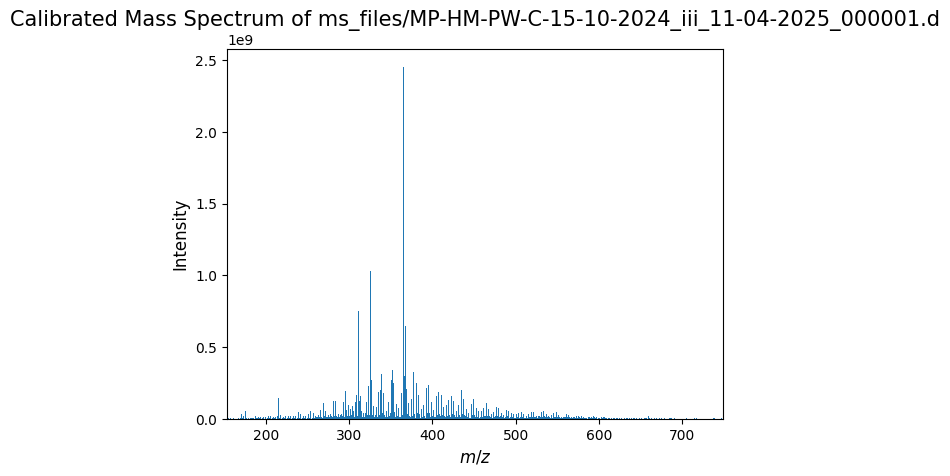

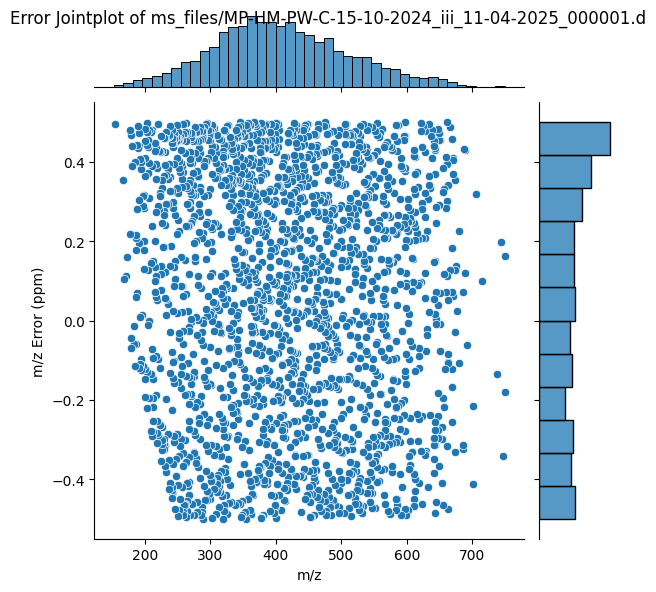

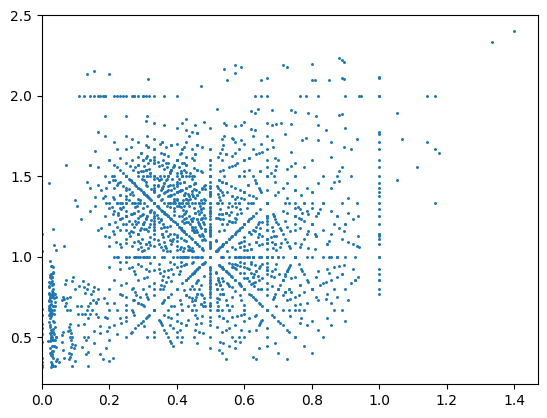

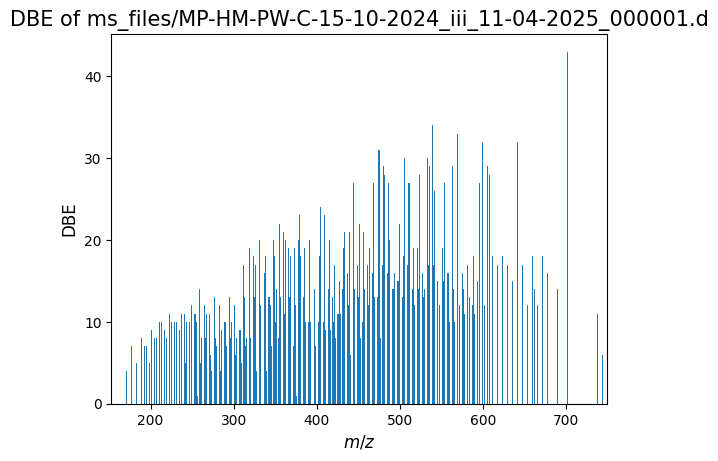

In [13]:
# Main processing loop

spectra_dfs = {}

# Process the spectra date by date so as to have the correct intrinsic error
for date in dates:
    samples_csv_df_bydate = samples_csv_df[samples_csv_df['date']==date]
    blanks_csv_df_bydate = blanks_csv_df[blanks_csv_df['date']==date]
    ctrl_csv_df_bydate = ctrl_csv_df[ctrl_csv_df['date']==date]

    unique_blanks = np.unique(blanks_csv_df['associated_name'])

    # Load the right value for the calibration ppm error threshold
    if calibration:
        if type(calib_ppm_error_threshold)==dict:
            calib_ppm_error_threshold_bydate = calib_ppm_error_threshold[date]
        else: calib_ppm_error_threshold_bydate = calib_ppm_error_threshold
    else: calib_ppm_error_threshold_bydate = None

    # Process the spectra sharing the same blanks together
    for blank in unique_blanks:
        associated_blank = give_associated_blank_name(blank)
        samples_csv_df_bydate_byblk = samples_csv_df_bydate[samples_csv_df_bydate['associated_blank']==associated_blank]
        blanks_csv_df_bydate_byblk = blanks_csv_df_bydate[blanks_csv_df_bydate['associated_name']==blank]

        #include decon90 ctrl too
        to_remove = pd.concat([blanks_csv_df_bydate_byblk.drop(['associated_name'], axis=1), ctrl_csv_df_bydate], ignore_index=True, axis=0)
        if decon90_file not in [None,'']:
            to_remove = pd.concat([to_remove, decon90_df], ignore_index=True, axis=0)

        # Process the spectra
        spectra_dfs, logs_txt = process_spectra(samples_csv_df_bydate_byblk['file_name'].to_numpy(),to_remove,spectra_dfs,calib_ppm_error_threshold_bydate,logs=logs,logs_txt=logs_txt)

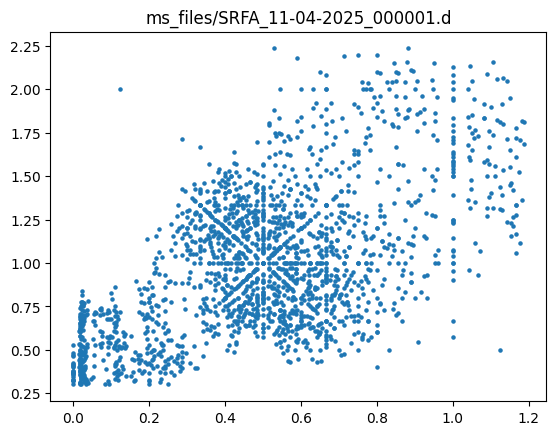

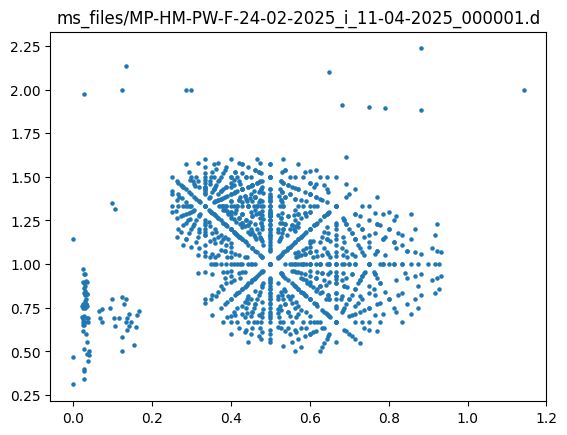

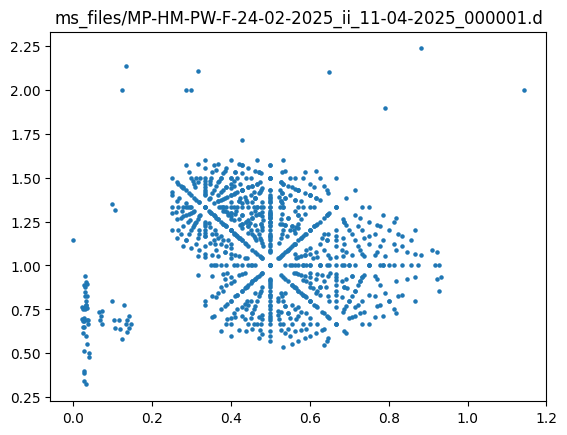

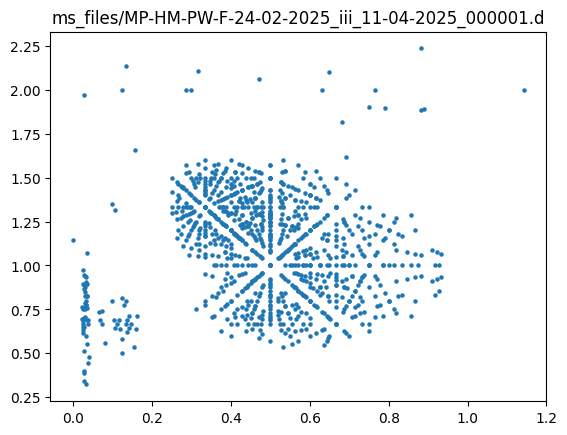

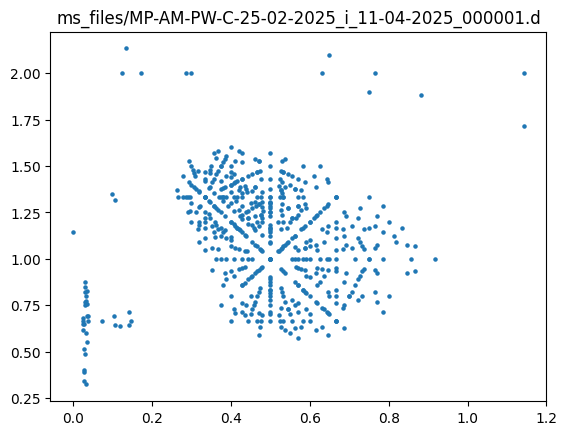

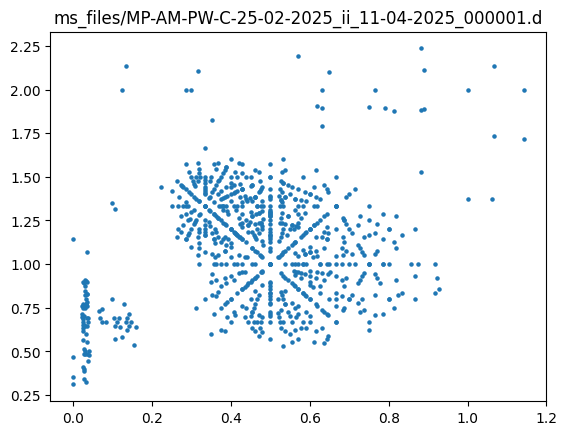

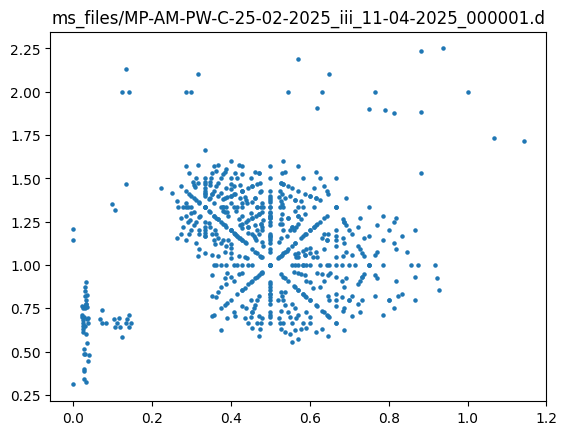

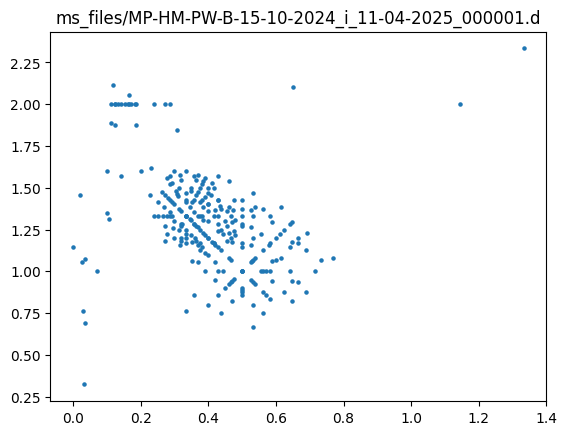

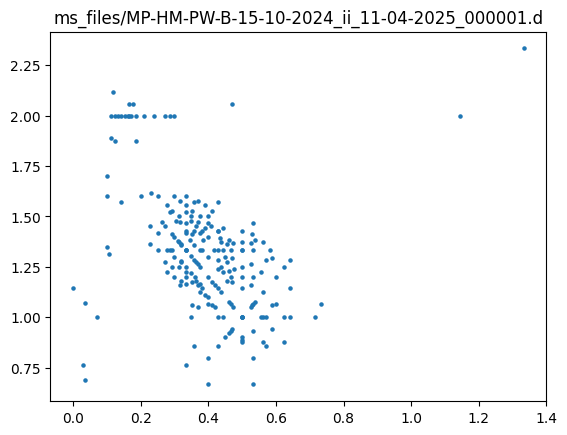

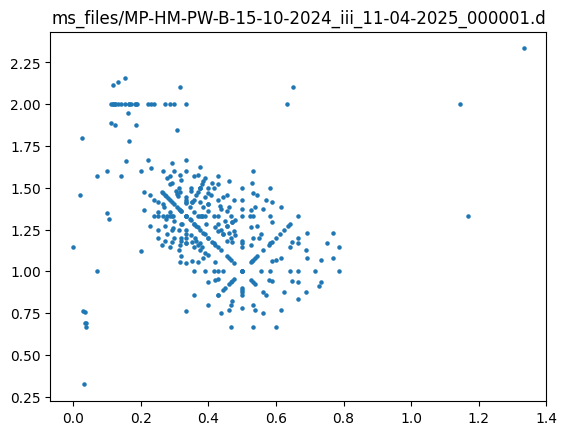

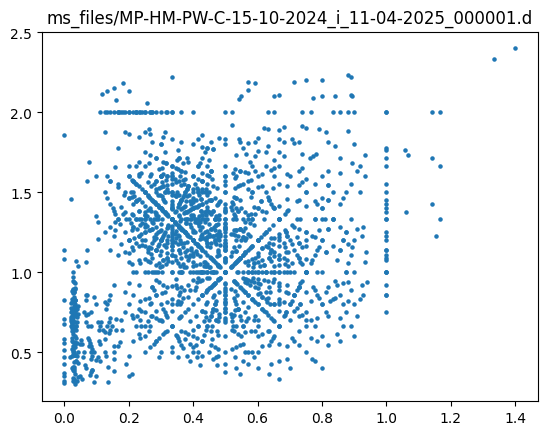

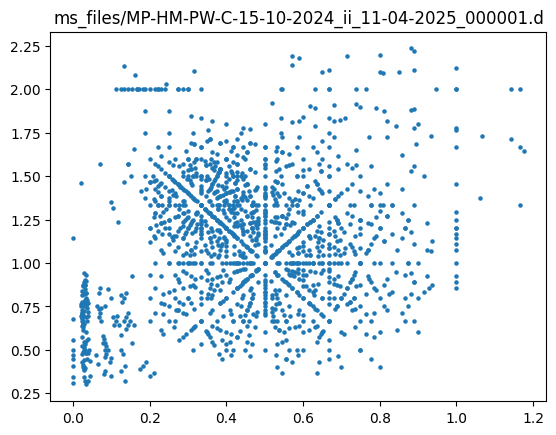

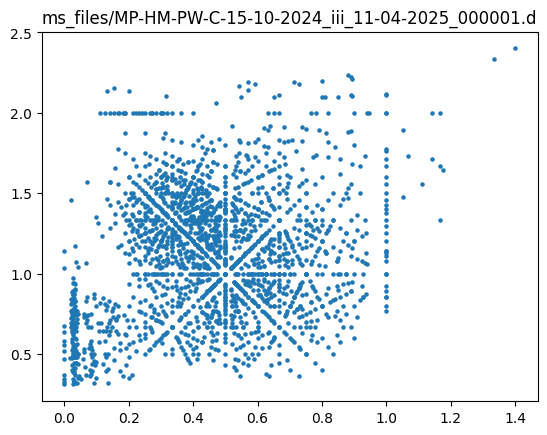

In [14]:
for s in spectra_dfs:
    fig, ax = plt.subplots()
    ax.scatter(spectra_dfs[s]['O/C'],spectra_dfs[s]['H/C'],s=5)
    ax.set_title(s)

In [15]:
if logs:
    with open(f'logs/{logs_title}', 'w') as f:
        f.write(logs_txt)

In [16]:
if calibration:
    for file in spectra_dfs:
        if 'SRFA' in file.upper():
            interlabTuple = pk.read_corems(spectra_dfs[file], mass_type= 'calibrated', verbose = True, remove_multiply_assigned_peaks = True)

            # Double check for interference from high molecular weight doubly charged ions 
            interlabTuple = pk.filter_spectral_interference(interlabTuple)

            # Export the results of the analysis to a csv file which can be uploaded at https://kairos.warwick.ac.uk/InterLabStudy/
            InterLabStudy = pd.DataFrame()
            InterLabStudy['m/z'] = interlabTuple.mz
            InterLabStudy['intensity'] = interlabTuple.intensity
            InterLabStudy['formula'] = interlabTuple.formula
            InterLabStudy.to_csv(f"CSV_files/interlab_csvs/{file.replace('ms_files/','').replace('.d','')}_interlabstudy.csv", index = False)

else: # Study intrinsic error distribution
    save_intr_err_cal_fig = 1

    date_no = 0 
    samples_csv_df_bydate = samples_csv_df[samples_csv_df['date']==samples_csv_df['date'].to_numpy()[date_no]]

    keys_idx = 0
    keys = list(spectra_dfs.keys())

    ppm_threshold_try = (0,3)

    for name in keys:
        jointplot = sns.jointplot(x='m/z', y='m/z Error (ppm)', data = spectra_dfs[name])

        jointplot.fig.suptitle(f"Error Jointplot of {name.replace(spectra_folder+'/','')}")
        jointplot.fig.tight_layout()
        
        ax = plt.gca()

        ax.axhline(np.min(ppm_threshold_try),c='r')
        xlim = ax.get_xlim()
        ax.text(np.min(xlim),np.min(ppm_threshold_try)*.95,f'{np.min(ppm_threshold_try)} ppm',color='r',va='top')
        ax.axhline(np.max(ppm_threshold_try),c='orange')
        ax.text(np.min(xlim),np.max(ppm_threshold_try)*1.05,f'{np.max(ppm_threshold_try)} ppm',color='orange')

        if save_intr_err_cal_fig:
            intr_err_path = 'intr_err_study_figures'
            if not os.path.exists(plots_folder): os.mkdir(plots_folder)
            if not os.path.exists(f'{plots_folder}/{intr_err_path}'): os.mkdir(f'{plots_folder}/{intr_err_path}')
            jointplot.fig.savefig(f"{plots_folder}/{intr_err_path}/intr_err_for_{name.replace('.d','').replace(spectra_folder+'/','')}.png",dpi=600, facecolor = '#fff', bbox_inches='tight')

total peaks: 7564
assigned peaks: 1697
generated formulae: 1761
**************************************************
64 multiply assigned peaks removed
----------------------------------------------------
0 interferences removed.
